In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from sqlalchemy import create_engine

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
from scipy.sparse import csr_matrix

In [6]:
import datetime as dt

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter('ignore')

# Data Pre-Processing

In [8]:
engine = create_engine("sqlite:///../db/twitter_db.sqlite")
conn = engine.connect()

In [9]:
tweets_df = pd.read_sql("SELECT * FROM tweet_data", conn)

In [10]:
tweets_df.head(2)

,id,created_at,created_at_time,created_at_date,created_at_datetime,tweet_id,tweet_id_str,full_text,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user_id,user_id_str,user_name,user_screen_name,retweet_count,favorite_count
0,1,Wed Jul 31 22:21:23 +0000 2019,22:21:23.000000,2019-07-31,2019-07-31 22:21:23.000000,1156691352983412737,1156691352983412737,"Here's the deal, President Trump inherited the...",NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,938,4134
1,2,Wed Jul 31 21:28:00 +0000 2019,21:28:00.000000,2019-07-31,2019-07-31 21:28:00.000000,1156677917469896704,1156677917469896704,I’ve got some exciting news: I am now on Snapc...,NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,173,790


In [11]:
len(tweets_df)

43421

In [12]:
tweets_df["created_at_datetime"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strptime(x,
                                                                "%Y-%m-%d %H:%M:%S.%f"))

In [13]:
tweets_df = tweets_df.loc[tweets_df["created_at_datetime"] < dt.datetime(2019,8,15), :].reset_index(drop=True)

In [14]:
len(tweets_df)

40678

In [15]:
grouped_df = tweets_df.groupby(tweets_df['user_name']).median()
grouped_df = grouped_df[['retweet_count']].sort_values('retweet_count', ascending = False).iloc[:7]
# grouped_df.sort_values('retweet_count', ascendingh = False)
grouped_df
top_candidates =[]
for i, r in grouped_df.iterrows():
    top_candidates.append(i)
# Remove Eric Swalwell from list (dropped out)
top_candidates.pop(3)
top_candidates

['Donald J. Trump',
 'Bernie Sanders',
 'Kamala Harris',
 'Elizabeth Warren',
 'Joe Biden',
 'Tulsi Gabbard']

In [16]:
tweets_df = tweets_df.loc[tweets_df['user_name'].isin(top_candidates), :].reset_index(drop=True)

In [17]:
len(tweets_df)

10520

In [18]:
tweets_df["day"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%A"))
tweets_df["hour"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%H"))
tweets_df["month"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%B"))

In [19]:
tweets_df.drop(columns = ["created_at", "created_at_time", "created_at_date","created_at_datetime",
                    "tweet_id", "tweet_id_str", "in_reply_to_status_id",
                    "in_reply_to_status_id_str", "in_reply_to_user_id",
                    "in_reply_to_user_id_str", "in_reply_to_screen_name",
                    "user_id_str", "user_id", "user_screen_name", "id"], inplace = True)

In [20]:
tweets_df = tweets_df[["user_name", "month", "day", "hour", "retweet_count", "favorite_count", "full_text"]]

In [21]:
tweets_df.head(2)

,user_name,month,day,hour,retweet_count,favorite_count,full_text
0,Joe Biden,July,Wednesday,22,938,4134,"Here's the deal, President Trump inherited the..."
1,Joe Biden,July,Wednesday,21,173,790,I’ve got some exciting news: I am now on Snapc...


In [22]:
len(tweets_df.groupby(tweets_df["user_name"]).count())

6

In [23]:
X_count_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_count_df = pd.get_dummies(X_count_df, columns = ["month", "day", "hour"])

In [24]:
X_count_df.head(2)

,full_text,retweet_count,favorite_count,month_April,month_August,month_December,month_February,month_January,month_July,month_June,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,"Here's the deal, President Trump inherited the...",938,4134,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,I’ve got some exciting news: I am now on Snapc...,173,790,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
import nltk
import re
import string
pd.set_option('display.max_colwidth', 100) # To extend column width

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

In [26]:
def clean_text(text):
    text = text.replace('&amp;', '&')
    text = text.replace('\n', ' ')
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Bag of Words

# Count Vectorizer

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer
count_vect = CountVectorizer(analyzer=clean_text)
X_count_vect = count_vect.fit_transform(X_count_df['full_text'])

In [86]:
X_count_df.drop(columns = ['full_text'], inplace = True)

In [87]:
X_count_df = pd.concat([X_count_df, pd.DataFrame(X_count_vect.toarray(), columns=count_vect.get_feature_names())], axis=1)

In [88]:
X_count_df.shape

(10520, 20445)

In [89]:
data_y = tweets_df.values
data_x = X_count_df.values
X_count = data_x[:, 0:]
y_count = data_y[:,0]

In [90]:
X_count

array([[  938,  4134,     0, ...,     0,     0,     0],
       [  173,   790,     0, ...,     0,     0,     0],
       [  712,  4376,     0, ...,     0,     0,     0],
       ...,
       [  741, 20234,     0, ...,     0,     0,     0],
       [18289, 68718,     0, ...,     0,     0,     0],
       [   11,    74,     0, ...,     0,     0,     0]], dtype=int64)

In [91]:
X_count.shape

(10520, 20445)

In [92]:
X_count_sparse = csr_matrix(X_count)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
from sklearn.preprocessing import MaxAbsScaler

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
from matplotlib.legend_handler import HandlerLine2D

In [39]:
# from keras.utils import to_categorical

## Train-Test-Split/Label-Encoding (Grid Search)

In [51]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_count_sparse, y_count, random_state=42,
                                                               train_size = 0.9,
                                                               shuffle = True)

In [52]:
X_scaler_cv = MaxAbsScaler().fit(X_train_cv)

In [53]:
X_train_scaled_cv = X_scaler_cv.transform(X_train_cv)
X_test_scaled_cv = X_scaler_cv.transform(X_test_cv)

In [54]:
# Step 1: Label-encode data set
label_encoder_cv = LabelEncoder()
label_encoder_cv.fit(y_train_cv)

encoded_y_train_cv = label_encoder_cv.transform(y_train_cv)
encoded_y_test_cv = label_encoder_cv.transform(y_test_cv)

In [55]:
encoded_y_train_cv = encoded_y_train_cv.reshape(-1, 1)
encoded_y_test_cv = encoded_y_test_cv.reshape(-1, 1)

## Train-Test-Split/Label Encoding (In-Depth Parameter Tuning)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_count_sparse, y_count, random_state=42)

In [57]:
X_scaler = MaxAbsScaler().fit(X_train)

In [58]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [59]:
X_train_scaled.shape

(7890, 20445)

In [60]:
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [61]:
encoded_y_train = encoded_y_train.reshape(-1, 1)
encoded_y_test = encoded_y_test.reshape(-1, 1)

## N_estimators (Count Vectorizer)

In [63]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

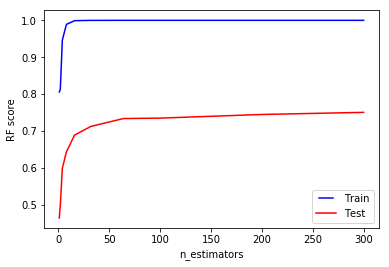

In [64]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# Best ~ 150 (100 - 300)

## Max-Depth (Count Vectorizer)

In [65]:
max_depths = list(np.linspace(1, 90, 90, endpoint=True))

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

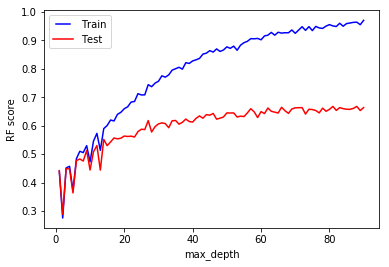

In [67]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depth')
plt.show()

In [ ]:
# Best ~ 15 (5 - 15)

## Min_samples_split (Count Vectorizer)

In [68]:
min_samples_splits = list(np.linspace(0.1, 1.0, 10, endpoint=True))

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)
    
    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

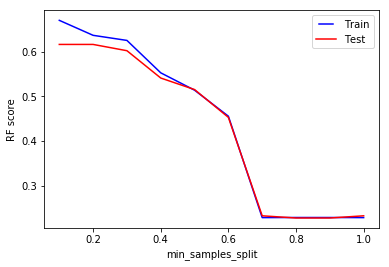

In [69]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_split')
plt.show()

In [ ]:
#Best ~ 150 (10-150)

## Min_samples_leaf (Count Vectorizer)

In [74]:
min_samples_leafs = list(np.linspace(.01, 0.5, 20, endpoint = True))

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

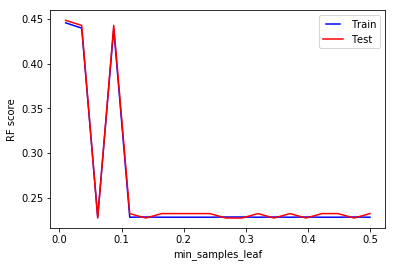

In [75]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_leaf')
plt.show()

## Max_features (Count Vectorizer)

In [76]:
max_features_list = list(range(1, 3000, 100))

train_results = []
test_results = []
for max_features in max_features_list:
    rf = RandomForestClassifier(max_features=max_features, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)
    
    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

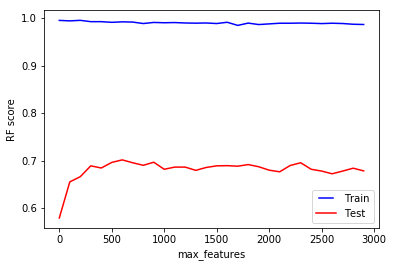

In [77]:
line1, = plt.plot(max_features_list, train_results, 'b', label="Train")
line2, = plt.plot(max_features_list, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_features')
plt.show()

## In-Depth Parameter Tuning Scoring (Count Vectorizer)

In [83]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 150)
rf = rf.fit(X_train_scaled, encoded_y_train)
rf.score(X_test_scaled, encoded_y_test)

0.5768060836501901

## GridSearch (Count Vectorizer)

In [85]:
max_depth_gs = list(range(5, 16, 2))
max_depth_gs.append(None)
max_depth_gs

[5, 7, 9, 11, 13, 15, None]

In [93]:
rf = RandomForestClassifier()
param = {'n_estimators': list(range(10, 151, 14)),
        'max_depth': max_depth_gs,
         'max_features': list(range(100, 301, 20))
        }

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, verbose = 3)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_train_scaled_cv, encoded_y_test_cv)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

Fitting 5 folds for each of 847 candidates, totalling 4235 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 4235 out of 4235 | elapsed: 53.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
746,41.710285,0.268752,0.220211,0.010334,None,120,136,"{'max_depth': None, 'max_features': 120, 'n_estimators': 136}",0.758839,0.764116,...,0.753802,0.006573,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
745,37.349943,0.239744,0.193483,0.003338,None,120,122,"{'max_depth': None, 'max_features': 120, 'n_estimators': 122}",0.750923,0.764116,...,0.750528,0.007902,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
747,45.895895,0.198123,0.256514,0.018928,None,120,150,"{'max_depth': None, 'max_features': 120, 'n_estimators': 150}",0.755145,0.757784,...,0.749261,0.006139,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
744,33.136408,0.181004,0.199068,0.020289,None,120,108,"{'max_depth': None, 'max_features': 120, 'n_estimators': 108}",0.758311,0.754617,...,0.749155,0.006283,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
791,48.997679,0.569041,0.228390,0.010171,None,200,150,"{'max_depth': None, 'max_features': 200, 'n_estimators': 150}",0.754617,0.754090,...,0.748521,0.005293,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [78]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=136, max_depth=None, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 120)
rf = rf.fit(X_train_scaled_cv, encoded_y_train_cv)
rf.score(X_test_scaled_cv, encoded_y_test_cv)

0.7557034220532319

# TF-IDF Vectorizer

In [97]:
X_tdidf_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_tdidf_df = pd.get_dummies(X_tdidf_df, columns = ["month", "day", "hour"])

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf_vect = tfidf_vect.fit_transform(X_tdidf_df['full_text'])

In [99]:
X_tdidf_df.drop(columns = ['full_text'], inplace = True)

In [100]:
X_tdidf_df = pd.concat([X_tdidf_df, pd.DataFrame(X_tfidf_vect.toarray(), columns=tfidf_vect.get_feature_names())], axis=1)

In [101]:
X_tdidf_df.shape

(10520, 20445)

In [102]:
data_y_idf = tweets_df.values
data_x_idf = X_tdidf_df.values
X_count_idf = data_x_idf[:, 0:]
y_count_idf = data_y_idf[:,0]

In [103]:
X_count_idf

array([[9.3800e+02, 4.1340e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7300e+02, 7.9000e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.1200e+02, 4.3760e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [7.4100e+02, 2.0234e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.8289e+04, 6.8718e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.1000e+01, 7.4000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [104]:
X_count_idf.shape

(10520, 20445)

In [105]:
y_count_idf

array(['Joe Biden', 'Joe Biden', 'Joe Biden', ..., 'Elizabeth Warren',
       'Elizabeth Warren', 'Elizabeth Warren'], dtype=object)

In [106]:
X_count_idf_sparse = csr_matrix(X_count_idf)

## Train-Test-Split/Label-Encoding (Grid Search)


In [107]:
X_train_idf_cv, X_test_idf_cv, y_train_idf_cv, y_test_idf_cv = train_test_split(X_count_idf_sparse, 
                                                                y_count_idf, random_state=42,
                                                               train_size = 0.9,
                                                               shuffle = True)

In [108]:
X_scaler_idf_cv = MaxAbsScaler().fit(X_train_idf_cv)

In [110]:
X_train_scaled_idf_cv = X_scaler_idf_cv.transform(X_train_idf_cv)
X_test_scaled_idf_cv = X_scaler_idf_cv.transform(X_test_idf_cv)

In [76]:
min_samples_leafs = list(np.linspace(.01, 0.5, 20, endpoint = True))

In [77]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

In [111]:
# Step 1: Label-encode data set
label_encoder_idf_cv = LabelEncoder()
label_encoder_idf_cv.fit(y_train_idf_cv)

encoded_y_train_idf_cv = label_encoder_idf_cv.transform(y_train_idf_cv)
encoded_y_test_idf_cv = label_encoder_idf_cv.transform(y_test_idf_cv)

In [112]:
encoded_y_train_idf_cv = encoded_y_train_idf_cv.reshape(-1, 1)
encoded_y_test_idf_cv = encoded_y_test_idf_cv.reshape(-1, 1)

# TF-IDF Vectorizer

## Train-Test-Split/Label-Encoding (In-Depth Parameter Tuning)

In [113]:
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(X_count_idf_sparse, y_count_idf, random_state=42,
                                                                   shuffle = True)

In [114]:
X_scaler_idf = MaxAbsScaler().fit(X_train_idf)

In [115]:
X_train_scaled_idf = X_scaler_idf.transform(X_train_idf)
X_test_scaled_idf = X_scaler_idf.transform(X_test_idf)

In [116]:
# Step 1: Label-encode data set
label_encoder_idf = LabelEncoder()
label_encoder_idf.fit(y_train_idf)

encoded_y_train_idf = label_encoder_idf.transform(y_train_idf)
encoded_y_test_idf = label_encoder_idf.transform(y_test_idf)

In [117]:
encoded_y_train_idf = encoded_y_train_idf.reshape(-1, 1)
encoded_y_test_idf = encoded_y_test_idf.reshape(-1, 1)

## In-Depth Parameter Tuning

## N-Estimators (TF-IDF Vectorizer)

In [118]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

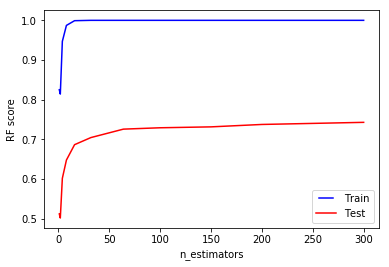

In [119]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('n_estimators')
plt.show()

In [120]:
# Best: n-estimators=150 (10 - 250)

## Max-Depth (TF-IDF Vectorizer)

In [121]:
max_depths = list(np.linspace(1, 90, 90, endpoint=True))

In [122]:
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

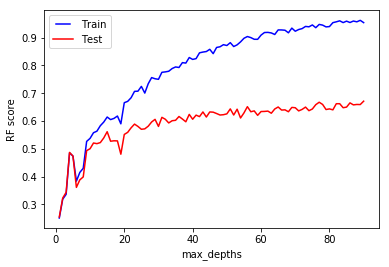

In [123]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depths')
plt.show()

In [124]:
#Best: max_depth= 8 (2-12)

## Min_samples_split (TF-IDF Vectorizer)

In [125]:
min_samples_splits = list(np.linspace(0.1, 1.0, 10, endpoint=True))

In [126]:
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

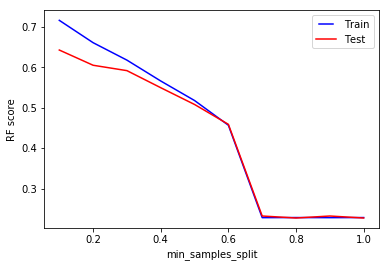

In [127]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_split')
plt.show()

In [128]:
# Best: min_samples_split=2

## Min_samples_leaf (TF-IDF Vectorizer)

In [129]:
min_samples_leafs = list(np.linspace(.01, 0.5, 20, endpoint = True))

In [130]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

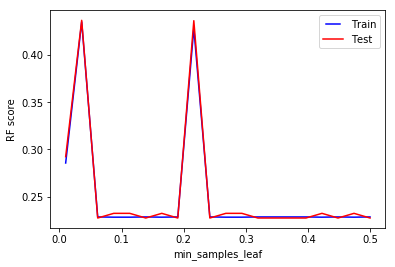

In [131]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_leaf')
plt.show()

In [132]:
#Best: min_samples_leaf = 1

## Max_Features (TF-IDF Vectorizer)

In [133]:
max_features_list = list(range(1, 3000, 100))

In [134]:
train_results = []
test_results = []
for max_features in max_features_list:
    rf = RandomForestClassifier(max_features=max_features, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)
    
    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

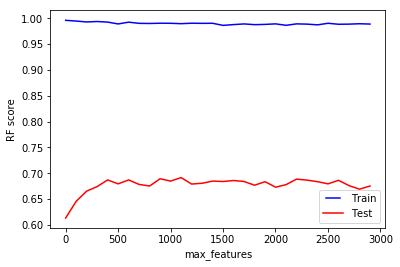

In [135]:
line1, = plt.plot(max_features_list, train_results, 'b', label="Train")
line2, = plt.plot(max_features_list, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_features')
plt.show()

In [136]:
#Best: max_features=200 (100-300)

## In-Depth Parameter Tuning Scoring (TF-IDF Vectorizer)

In [137]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 250)
rf = rf.fit(X_train_scaled_idf, encoded_y_train_idf)
rf.score(X_test_scaled_idf, encoded_y_test_idf)

0.5338403041825095

## Grid Search (TF-IDF Vectorizer)

In [139]:
max_depth_gs = list(range(2, 20, 2))
max_depth_gs.append(None)
max_depth_gs

[2, 4, 6, 8, 10, 12, 14, 16, 18, None]

In [140]:
rf = RandomForestClassifier()
param = {'n_estimators': list(range(10, 251, 24)),
        'max_depth': max_depth_gs,
         'max_features': list(range(100, 301, 20))
        }

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, verbose = 2)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_train_scaled_idf_cv, encoded_y_train_idf_cv)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

Fitting 5 folds for each of 1210 candidates, totalling 6050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 93.5min
[Parallel(n_jobs=-1)]: Done 6050 out of 6050 | elapsed: 117.8min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1099,90.682376,5.896368,0.576653,0.108677,None,100,250,"{'max_depth': None, 'max_features': 100, 'n_estimators': 250}",0.747757,0.765172,...,0.751267,0.007613,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1109,78.301259,4.406743,0.477323,0.089848,None,120,226,"{'max_depth': None, 'max_features': 120, 'n_estimators': 226}",0.748813,0.765172,...,0.749894,0.008875,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1121,96.928682,8.471812,0.528389,0.060901,None,140,250,"{'max_depth': None, 'max_features': 140, 'n_estimators': 250}",0.748813,0.758311,...,0.749155,0.004986,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1098,82.389259,4.882207,0.460768,0.029015,None,100,226,"{'max_depth': None, 'max_features': 100, 'n_estimators': 226}",0.744591,0.760422,...,0.748416,0.006573,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1097,76.884448,4.215021,0.452987,0.029461,None,100,202,"{'max_depth': None, 'max_features': 100, 'n_estimators': 202}",0.745119,0.755145,...,0.747676,0.004125,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=136, max_depth=None, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 120)
rf = rf.fit(X_train_scaled_cv, encoded_y_train_cv)
rf.score(X_test_scaled_cv, encoded_y_test_cv)